# Functional Constraints for Olivetti Faces
This notebook explores the `PySensors` General QR `GQR` optimizer and the `constraints` class within `utils` for spatially-constrained sparse sensor placement (for reconstruction) of the Olivetti Faces Dataset.

The General QR algorithm was devised specifically to solve such problems. The `PySensors` object implementing this method is named `GQR` and in this notebook we particularly showcase the functionalities offered by the constraints class. For example if the user provides the center and radius of a circular constrained region, the constraints in utils compute the constrained sensor indices. Direct constraint plotting, sensor numbering, showcasing sifference between constrained and unconstrained sensor locations have also been developed.

The constrained shapes currently implemented are:

Circle

Cylinder

Line

Parabola

Ellipse

Polygon

UserDefinedConstraints

This type of constraint has the ability to take in either a function from the user or a
.py file which contains a functional definition of the constrained region.

See the following reference for more information ([link1](https://ieeexplore.ieee.org/abstract/document/10453459), [link2](https://www.mdpi.com/1996-1073/17/13/3355))

Karnik N, Abdo MG, Estrada-Perez CE, Yoo JS, Cogliati JJ, Skifton RS, Calderoni P, Brunton SL, Manohar K. Constrained optimization of sensor placement for nuclear digital twins. IEEE Sensors Journal. 2024 Feb 28.

Karnik N, Wang C, Bhowmik PK, Cogliati JJ, Balderrama Prieto SA, Xing C, Klishin AA, Skifton R, Moussaoui M, Folsom CP, Palmer JJ, Sabharwall P, Manohar K, Abdo MG., Leveraging Optimal Sparse Sensor Placement to Aggregate a Network of Digital Twins for Nuclear Subsystems. Energies (19961073). 2024 Jul 1;17(13).

In [1]:
import pysensors as ps
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Circle

### Load the Olivetti Dataset
We'll consider the Olivetti faces dataset from AT&T. Our goal will be to reconstruct images of faces from a limited set of measurements.

First we've got to load and preprocess the data.

In [2]:
faces = datasets.fetch_olivetti_faces(shuffle=True, random_state=99)
X = faces.data

n_samples, n_features = X.shape
print(n_samples, n_features)

400 4096


In [3]:
# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

In [4]:
# From https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

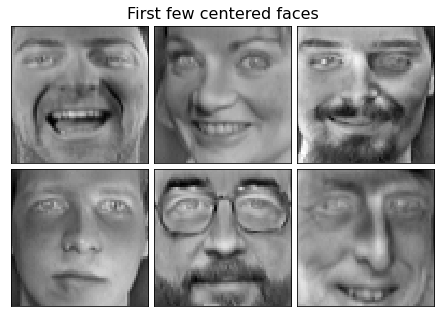

In [5]:
plot_gallery("First few centered faces", X[:n_components])

We'll learn the sensors using the first 300 faces and use the rest for testing reconstruction error.

In [6]:
X_train, X_test = X[:300], X[300:]

### Unconstrained sensor placement:
Consider the case where we treat all sensor locations as being equally viable.

In [7]:
n_sensors = 10
n_modes = 10
basis_unconst = ps.basis.SVD(n_basis_modes = n_modes)
optimizer_unconst = ps.optimizers.QR()
model_unconst = ps.SSPOR(basis = basis_unconst, optimizer = optimizer_unconst, n_sensors = n_sensors)
model_unconst.fit(X_train)
all_sensors_unconst = model_unconst.get_all_sensors()
sensors_unconst = model_unconst.get_selected_sensors()
print('The list of sensors selected is: {}'.format(sensors_unconst))

The list of sensors selected is: [4032  594  384  878  446 2772 4041 3936  340 2273]


In [8]:
# Direct function to get the coordinates of the sensors
xTopUnc,yTopUnc = ps.utils._constraints.get_coordinates_from_indices(sensors_unconst,info = X_train) # Info is the training data in case of an image dataset

In [9]:
#Sensor ID corresponds to the column number chosen
columns = ['Sensor ID','SensorX','sensorY']
unconstrainedSensors_df = pd.DataFrame(data = np.vstack([sensors_unconst,xTopUnc,yTopUnc]).T,columns=columns,dtype=int)
unconstrainedSensors_df.head(n_sensors)

,Sensor ID,SensorX,sensorY
0,4032,0,63
1,594,18,9
2,384,0,6
3,878,46,13
4,446,62,6
5,2772,20,43
6,4041,9,63
7,3936,32,61
8,340,20,5
9,2273,33,35


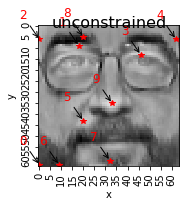

In [10]:
# Plot the unconstrained sensors
image = X_train[4,:].reshape(1,-1)

plot_gallery('unconstrained', image, n_col=1, n_row=1, cmap=plt.cm.gray)
plt.plot(xTopUnc, yTopUnc,'*r')
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(np.arange(0,64,5),rotation=90)
plt.yticks(np.arange(0,64,5),rotation=90)
for ind,i in enumerate(range(len(xTopUnc))):
    plt.annotate(f"{str(ind)}",(xTopUnc[i],yTopUnc[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))

### Circular Constraints: 

To constrain a circular region with center (20,5) and radius 5 units, we create an instance of the Circle class as demonstrated below. The data argument is essential for defining the constraint—since the Olivetti faces dataset contains image data, we pass the numpy array (X_train) as the data parameter. For tabular datasets, a dataframe would be used instead

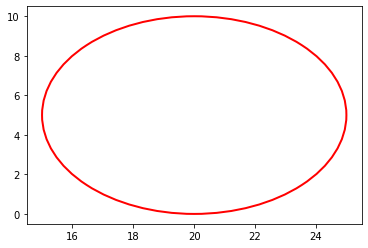

In [11]:
circle = ps.utils._constraints.Circle(center_x = 20, center_y = 5, radius = 5, loc = 'in', data = X_train) #Plotting the constrained circle 
circle.draw_constraint() ###Plotting just the constraint

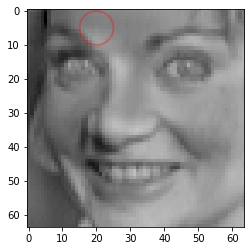

In [12]:
circle.plot_constraint_on_data(plot_type='image') ##Plotting the constraint on the data

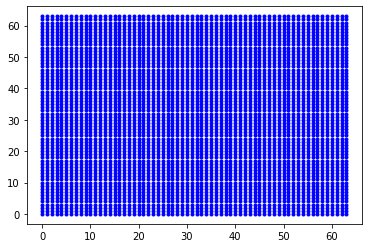

In [13]:
circle.plot_grid(all_sensors=all_sensors_unconst) #Provides the grid of all possible sensor locations

##### Obtaining constrained indices:
The primary step in constraint sensing is identifying which sensors fall within the constraint region. This is accomplished using the following function, which can handle different constraint region shapes:

In [14]:
const_idx, rank = circle.get_constraint_indices(all_sensors = all_sensors_unconst,info= X_train)  #get_indices

In [15]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 4 #Suppose we want to select exactly 4 sensors within the constraint region
# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_circle = ps.optimizers.GQR()
opt_exact_kws={'idx_constrained':const_idx,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_exact = ps.basis.SVD(n_basis_modes=n_sensors)

In [16]:
# Initialize and fit the model
model_exact = ps.SSPOR(basis = basis_exact, optimizer = optimizer_circle, n_sensors = n_sensors)
model_exact.fit(X_train,**opt_exact_kws)

# sensor locations based on columns of the data matrix
top_sensors_exact = model_exact.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConst = np.mod(top_sensors_exact,np.sqrt(n_features))
yTopConst = np.floor(top_sensors_exact/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_exact))

The list of sensors selected is: [4032  594  384  878  446 2772 4041  340  660  144]


In [17]:
data_sens_circle = circle.sensors_dataframe(sensors = top_sensors_exact) # Creating a dataframe of the constrained sensors
data_sens_circle

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,4041.0,9.0,63.0
7,340.0,20.0,5.0
8,660.0,20.0,10.0
9,144.0,16.0,2.0


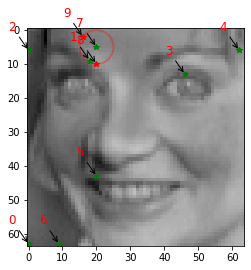

In [18]:
circle.plot_constraint_on_data(plot_type='image') # Plotting the constraint on the data
circle.plot_selected_sensors(sensors = top_sensors_exact, all_sensors = all_sensors_unconst) #Plotting the selected sensors on the constraint
circle.annotate_sensors(sensors = top_sensors_exact, all_sensors = all_sensors_unconst)

As demonstrated above, the constraint functions allow us to visualize the selected sensors on a data snapshot. Unconstrained sensors are displayed as green stars, while sensors modified by the constraint regions appear as red stars. This visualization clearly illustrates how sensor placement changes when constraints are applied. The sensor ranking annotations indicate relative importance, with lower-numbered sensors being the most critical.

### Linear Constraints
To constrain the region beyond a line defined by the coordinates x = 10, x = 20, y = 0, and y = 64, we create an instance of the Line class as demonstrated below.

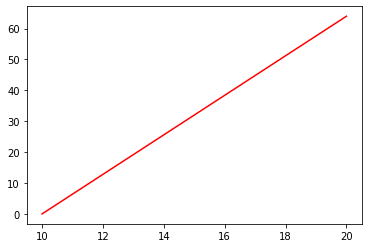

In [19]:
line1 = ps.utils._constraints.Line(x1 = 10, x2 = 20, y1 = 0, y2 = 64, data = X_train) #Plotting the constrained line  ##expect a tuple of (x,y)
line1.draw_constraint() ## plotting just the constraint

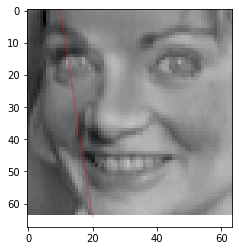

In [20]:
line1.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data

In [21]:
const_idx1, rank1 = line1.get_constraint_indices(all_sensors=all_sensors_unconst, info = X_train)

In [22]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 2

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_line = ps.optimizers.GQR()
opt_line_kws={'idx_constrained':const_idx1,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_line = ps.basis.SVD(n_basis_modes=n_sensors)

In [23]:
# Initialize and fit the model
model_line = ps.SSPOR(basis = basis_line, optimizer = optimizer_line, n_sensors = n_sensors)
model_line.fit(X_train,**opt_line_kws)

# sensor locations based on columns of the data matrix
top_sensors_line = model_line.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstLine = np.mod(top_sensors_line,np.sqrt(n_features))
yTopConstLine = np.floor(top_sensors_line/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_exact))

The list of sensors selected is: [4032  594  384  878  446 2772 4041  340  660  144]


In [24]:
data_sens_line = line1.sensors_dataframe(sensors = top_sensors_line)
data_sens_line

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,4041.0,9.0,63.0
5,3987.0,19.0,62.0
6,3268.0,4.0,51.0
7,1667.0,3.0,26.0
8,3217.0,17.0,50.0
9,770.0,2.0,12.0


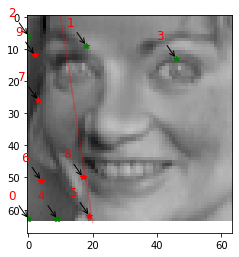

In [25]:
line1.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!
line1.plot_selected_sensors(sensors = top_sensors_line, all_sensors = all_sensors_unconst)
line1.annotate_sensors(sensors = top_sensors_line, all_sensors = all_sensors_unconst)

As demonstrated above, when we limit the constrained region to just 2 sensors, the remaining sensors are relocated to unconstrained areas. The most important sensors (ranked 1 and 3) remain within the constraint region since two sensors are permitted in this zone.

### Elliptical Constraints:
To constrain an elliptical region using specified center coordinates, width, height, and rotation angle, we can implement it as follows:

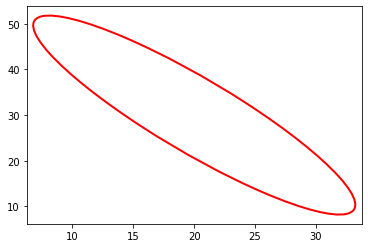

In [26]:
ellipse = ps.utils._constraints.Ellipse(center_x = 20, center_y = 30, width = 10, height = 50, angle=30,loc = 'in',data = X_train) #Plotting the constrained circle 
ellipse.draw_constraint() ###Plotting just the constraint

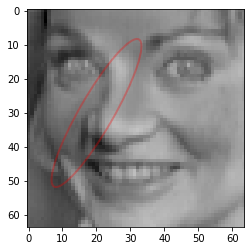

In [27]:
ellipse.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data

In [28]:
const_idx_ellipse, rank_ellipse = ellipse.get_constraint_indices(all_sensors=all_sensors_unconst, info = X_train)

In [29]:
# Define the number of constrained sensors allowed (s)
n_const_sen_ellipse = 3

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_ellipse = ps.optimizers.GQR()
opt_ellipse_kws={'idx_constrained':const_idx_ellipse,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sen_ellipse,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_ellipse = ps.basis.SVD(n_basis_modes=n_sensors)

In [30]:
# Initialize and fit the model
model_ellipse = ps.SSPOR(basis = basis_ellipse, optimizer = optimizer_ellipse, n_sensors = n_sensors)
model_ellipse.fit(X_train,**opt_ellipse_kws)

# sensor locations based on columns of the data matrix
top_sensors_ellipse = model_ellipse.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstEllipse = np.mod(top_sensors_ellipse,np.sqrt(n_features))
yTopConstEllipse = np.floor(top_sensors_ellipse/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_ellipse))

The list of sensors selected is: [4032  594  384  878  446 2772 4041 1559 3273 3022]


In [31]:
data_sens_ellipse = ellipse.sensors_dataframe(sensors = top_sensors_ellipse)
data_sens_ellipse

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,4041.0,9.0,63.0
7,1559.0,23.0,24.0
8,3273.0,9.0,51.0
9,3022.0,14.0,47.0


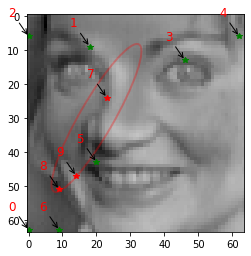

In [32]:
ellipse.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!
ellipse.plot_selected_sensors(sensors = top_sensors_ellipse, all_sensors = all_sensors_unconst)
ellipse.annotate_sensors(sensors = top_sensors_ellipse, all_sensors = all_sensors_unconst)

As demonstrated above, when constraining exactly 3 sensors within an elliptical region, the algorithm relocates less important sensors outside the constraint area to maintain optimal sensor placement while satisfying the constraint requirements.

### Convex Polygonal Constraints
A convex polygon is one where all interior angles are less than $180\degree$. To constrain sensors within a convex polygonal region—for example, to exclude all sensors from a polygon by allowing exactly zero sensors within it—we begin by initializing the Polygon class with the (x,y) coordinate points as shown below:

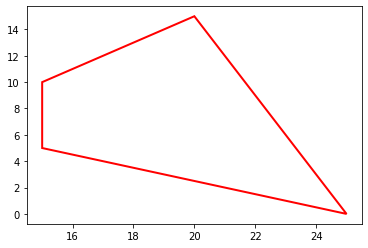

In [33]:
polygon = ps.utils._constraints.Polygon([(20,15),(25,0),(15,5),(15,10)],data = X_train) #Plotting the constrained circle 
polygon.draw_constraint() ###Plotting just the constraint

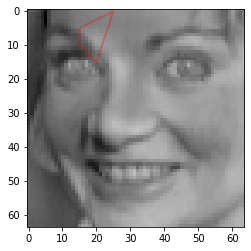

In [34]:
polygon.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!

In [35]:
const_idx_polygon, rank_polygon = polygon.get_constraint_indices(all_sensors=all_sensors_unconst, info = X_train)

In [36]:
# Define the number of constrained sensors allowed (s)
n_const_sen_polygon = 0

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_polygon = ps.optimizers.GQR()
opt_polygon_kws={'idx_constrained':const_idx_polygon,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sen_polygon,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_polygon = ps.basis.SVD(n_basis_modes=n_sensors)

In [37]:
# Initialize and fit the model
model_polygon = ps.SSPOR(basis = basis_polygon, optimizer = optimizer_polygon, n_sensors = n_sensors)
model_polygon.fit(X_train,**opt_polygon_kws)

# sensor locations based on columns of the data matrix
top_sensors_polygon = model_polygon.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstPolygon = np.mod(top_sensors_polygon,np.sqrt(n_features))
yTopConstPolygon = np.floor(top_sensors_polygon/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_polygon))

The list of sensors selected is: [4032  590  384  878  446 2772 4041 3936  429 2479]


In [38]:
data_sens_polygon = polygon.sensors_dataframe(sensors = top_sensors_polygon)
data_sens_polygon

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,590.0,14.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,4041.0,9.0,63.0
7,3936.0,32.0,61.0
8,429.0,45.0,6.0
9,2479.0,47.0,38.0


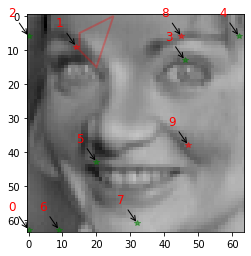

In [39]:
polygon.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!
polygon.annotate_sensors(sensors = top_sensors_polygon, all_sensors = all_sensors_unconst)

Since exactly zero sensors are permitted within the polygonal constraint region, we can observe that sensors 1 and 9 have been relocated to the next optimal positions outside the restricted area.

### Non convex polygonal Constraints
A non-convex polygon is one where at least one of the interior angles is greater than $180\degree$. To constrain sensors within a non- convex polygonal region—for example, to exclude all sensors from a polygon by allowing exactly zero sensors within it—we begin by initializing the Polygon class with the (x,y) coordinate points as shown below:

In [40]:
polygon2 = ps.utils._constraints.Polygon([(20,15),(25,0),(15,5),(20,7)],data = X_train) #Plotting the constrained circle 

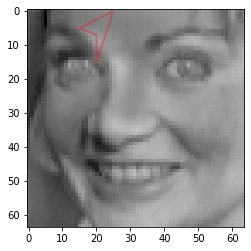

In [41]:
polygon2.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!

In [42]:
const_idx_polygon2, rank_polygon2 = polygon2.get_constraint_indices(all_sensors=all_sensors_unconst, info = X_train)


In [43]:
# Define the number of constrained sensors allowed (s)
n_const_sen_polygon = 3

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_polygon2 = ps.optimizers.GQR()
opt_polygon_kws2={'idx_constrained':const_idx_polygon2,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sen_polygon,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"max_n"}
basis_polygon = ps.basis.SVD(n_basis_modes=n_sensors)

In [44]:
# Initialize and fit the model
model_polygon2 = ps.SSPOR(basis = basis_polygon, optimizer = optimizer_polygon2, n_sensors = n_sensors)
model_polygon2.fit(X_train,**opt_polygon_kws2)

# sensor locations based on columns of the data matrix
top_sensors_polygon2 = model_polygon2.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstPolygon2 = np.mod(top_sensors_polygon2,np.sqrt(n_features))
yTopConstPolygon2 = np.floor(top_sensors_polygon2/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_polygon2))

The list of sensors selected is: [4032  594  384  878  446 2772 4041 3936  340 2273]


In [45]:
data_sens_polygon2 = polygon2.sensors_dataframe(sensors = top_sensors_polygon2)
data_sens_polygon2

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,4041.0,9.0,63.0
7,3936.0,32.0,61.0
8,340.0,20.0,5.0
9,2273.0,33.0,35.0


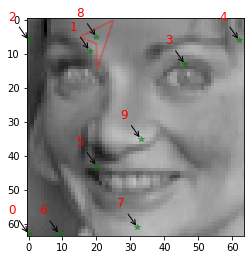

In [46]:
polygon2.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!
polygon2.annotate_sensors(sensors = top_sensors_polygon2, all_sensors = all_sensors_unconst)

Since a maximum of 3 sensors are allowed within the non-convex polygonal region, and only one sensor was located in this area in the unconstrained case, no changes occur in the constrained scenario—the single sensor remains permissible within the 3-sensor limit.

### User defined constraints (Input File)
When users need to define complex constraints using custom Python functions, they can implement them as shown below. For example, to create a circular constraint centered at (30, 40) with radius 5:
```
    def userExplicitConstraint1(x, y, **kwargs):

    assert len(x) == len(y)

    g = np.zeros(len(x), dtype=float)

    for i in range(len(x)):

        g[i] = ((x[i] - 30) ** 2 + (y[i] - 40) ** 2) - 5**2

    return g
```


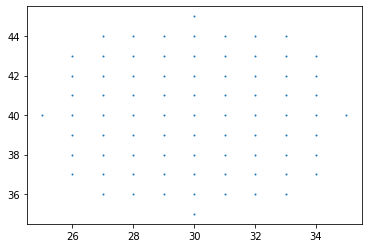

In [47]:
user_const = 'helper_scripts/userExplicitConstraint1.py'
user_const_instance = ps.utils._constraints.UserDefinedConstraints(all_sensors_unconst,data = X_train, file = user_const)
idx, rank = user_const_instance.constraint()
user_const_instance.draw_constraint() ## plot the user defined constraint just by itself

In [48]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 0

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_user = ps.optimizers.GQR()
opt_user_kws={'idx_constrained':idx,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_user = ps.basis.SVD(n_basis_modes=n_sensors)

In [49]:
# Initialize and fit the model
model_user = ps.SSPOR(basis = basis_user, optimizer = optimizer_user, n_sensors = n_sensors)
model_user.fit(X_train,**opt_user_kws)

# sensor locations based on columns of the data matrix
top_sensors_user = model_user.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstUser = np.mod(top_sensors_user,np.sqrt(n_features))
yTopConstUser = np.floor(top_sensors_user/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_exact))

The list of sensors selected is: [4032  594  384  878  446 2772 4041  340  660  144]


In [50]:
data_sens_user = user_const_instance.sensors_dataframe(sensors = top_sensors_user)
data_sens_user

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,4041.0,9.0,63.0
7,3936.0,32.0,61.0
8,340.0,20.0,5.0
9,2273.0,33.0,35.0


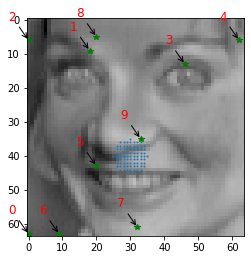

In [51]:
user_const_instance.plot_constraint_on_data(plot_type='image') 
user_const_instance.plot_selected_sensors(sensors = top_sensors_user, all_sensors = all_sensors_unconst)
user_const_instance.annotate_sensors(sensors = top_sensors_user, all_sensors= all_sensors_unconst)

Since no sensors are permitted within the constraint region and none were previously located there in the unconstrained case, the original sensor placement remains unchanged and serves as the final configuration.

### User defined constraints (Input String)
Now let us consider an example where the user inputs the equation that they are considering as a constraint in a string of the form $(x-30)^2 + (y-40)^2 < 25$

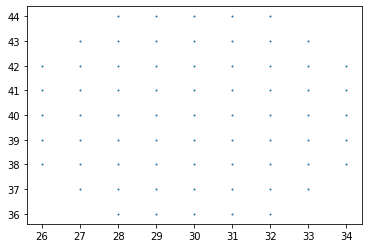

In [52]:
user_const_stg = '(x-30)**2 + (y-40)**2 < 5**2'
user_const_stg_instance = ps.utils._constraints.UserDefinedConstraints(all_sensors_unconst,data = X_train, equation = user_const_stg)
idx_stg, rank_stg = user_const_stg_instance.constraint()
user_const_stg_instance.draw_constraint() ## plot the user defined constraint just by itself

In [53]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 0

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_user_stg = ps.optimizers.GQR()
opt_user_kws_stg={'idx_constrained':idx_stg,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_user_stg = ps.basis.SVD(n_basis_modes=n_sensors)

In [54]:
# Initialize and fit the model
model_user_stg = ps.SSPOR(basis = basis_user_stg, optimizer = optimizer_user_stg, n_sensors = n_sensors)
model_user_stg.fit(X_train,**opt_user_kws_stg)

# sensor locations based on columns of the data matrix
top_sensors_user_stg = model_user_stg.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstUser_stg = np.mod(top_sensors_user_stg,np.sqrt(n_features))
yTopConstUser_stg = np.floor(top_sensors_user_stg/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_user_stg))

The list of sensors selected is: [4032  594  384  878  446 2772 4041 3936  340 2273]


In [55]:
data_sens_user_stg = user_const_stg_instance.sensors_dataframe(sensors = top_sensors_user_stg)
data_sens_user_stg

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,4041.0,9.0,63.0
7,3936.0,32.0,61.0
8,340.0,20.0,5.0
9,2273.0,33.0,35.0


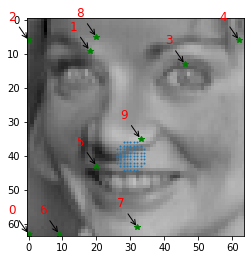

In [56]:
## Verifying whther user-defined constraints work

user_const_stg_instance.plot_constraint_on_data(plot_type='image') 
user_const_stg_instance.plot_selected_sensors(sensors = top_sensors_user_stg, all_sensors = all_sensors_unconst)
user_const_stg_instance.annotate_sensors(sensors = top_sensors_user_stg, all_sensors= all_sensors_unconst)

- As demonstrated above, we again observe 0 sensors within the circular constraint region, which aligns with the unconstrained case that also had no sensors in that area and the previous example. 
- Through these examples, we demonstrate how various constraint regions can be established and highlight the multiple approaches available for defining them, including user-defined input files and string-based specifications.